<a href="https://colab.research.google.com/github/gsakkar/ML/blob/main/supervised-learning/notebook/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classification with Custom Training Loop

In this notebook, we will explore how to build and train a Decision Tree model using the Breast Cancer dataset. We will also define a custom training loop to monitor the model's performance over epochs.

## Step 1: Importing Necessary Libraries

We need several libraries for this task:
- `tensorflow` for defining the custom model class
- `sklearn` for loading the dataset, splitting the data, and calculating metrics
- `numpy` for numerical operations
- `matplotlib` for plotting the training history
- `DecisionTreeClassifier` from `sklearn.tree` for our decision tree model

In [1]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

## Step 2: Loading the Breast Cancer Dataset

The Breast Cancer dataset is a well-known dataset in machine learning. It contains 569 samples of breast cancer cases, each with 30 features describing the characteristics of the cell nuclei present in the image. The target variable indicates whether the cancer is malignant or benign.

In [2]:
# Load the breast cancer dataset
data = load_breast_cancer()
x, y = data.data, data.target

## Step 3: Splitting the Data into Training and Testing Sets

We split the dataset into training and testing sets to evaluate our model. The training set is used to train the model, while the testing set is used to evaluate its performance on unseen data. We use an 80-20 split for training and testing, respectively.

In [3]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Step 4: Defining the Custom Decision Tree Model

We define a custom model class `MyDecisionTree` by subclassing `tf.keras.Model`. This class will contain:
- An instance of `DecisionTreeClassifier` from `sklearn.tree`
- A custom training loop to simulate epoch-based training for the decision tree
- Methods for predicting, evaluating, and calculating various performance metrics
- A method for plotting the training history

In [4]:
class MyDecisionTree(tf.keras.Model):
    def __init__(self):
        super(MyDecisionTree, self).__init__()
        self.tree = DecisionTreeClassifier(criterion='entropy')
        self.history = {
            'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [],
            'val_loss': [], 'val_accuracy': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
        }

    def call(self, inputs):
        return self.tree.predict(inputs)

    def fit(self, x, y, epochs=1, batch_size=32, validation_split=0.2, **kwargs):
        """
        Trains the decision tree model on the input data and tracks performance over epochs.

        This method simulates epoch-based training for decision trees by retraining the model
        in each epoch and recording various performance metrics.

        Parameters:
            x (numpy.ndarray): The feature matrix of the training data.
            y (numpy.ndarray): The target values or labels of the training data.
            epochs (int): Number of training epochs.
            batch_size (int): Size of batches for training (not used in decision trees).
            validation_split (float): Fraction of data to use for validation.
        """
        # Split the data into training and validation sets
        val_size = int(len(x) * validation_split)
        x_train, x_val = x[:-val_size], x[-val_size:]
        y_train, y_val = y[:-val_size], y[-val_size:]

        for epoch in range(epochs):
            # Train the model
            self.tree.fit(x_train, y_train)

            # Calculate metrics for training set
            train_pred = self.predict(x_train)
            train_pred_rounded = train_pred.round()
            train_metrics = self.calculate_metrics(y_train, train_pred, train_pred_rounded)

            # Calculate metrics for validation set
            val_pred = self.predict(x_val)
            val_pred_rounded = val_pred.round()
            val_metrics = self.calculate_metrics(y_val, val_pred, val_pred_rounded)

            # Store the metrics
            for metric, value in train_metrics.items():
                self.history[metric].append(value)
            for metric, value in val_metrics.items():
                self.history[f'val_{metric}'].append(value)

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train - loss: {train_metrics['loss']:.4f}, accuracy: {train_metrics['accuracy']:.4f}, "
                  f"precision: {train_metrics['precision']:.4f}, recall: {train_metrics['recall']:.4f}, "
                  f"f1: {train_metrics['f1']:.4f}")
            print(f"Val - loss: {val_metrics['loss']:.4f}, accuracy: {val_metrics['accuracy']:.4f}, "
                  f"precision: {val_metrics['precision']:.4f}, recall: {val_metrics['recall']:.4f}, "
                  f"f1: {val_metrics['f1']:.4f}")

    def predict(self, x):
        return self.tree.predict(x)

    def evaluate(self, x, y, **kwargs):
        """
        Evaluates the model's performance on the given data.

        Parameters:
            x (numpy.ndarray): The feature matrix of the test data.
            y (numpy.ndarray): The true target values or labels of the test data.

        Returns:
            dict: A dictionary containing various performance metrics.
        """
        y_pred = self.predict(x)
        y_pred_rounded = y_pred.round()
        return self.calculate_metrics(y, y_pred, y_pred_rounded)

    def calculate_metrics(self, y_true, y_pred, y_pred_rounded):
        """
        Calculates various performance metrics for the model.

        Parameters:
            y_true (numpy.ndarray): The true labels.
            y_pred (numpy.ndarray): The predicted probabilities or continuous values.
            y_pred_rounded (numpy.ndarray): The rounded predictions (for classification metrics).

        Returns:
            dict: A dictionary containing the following metrics:
                - loss: Mean Squared Error (MSE)
                - accuracy: Proportion of correct predictions
                - precision: Ability of the classifier not to label as positive a sample that is negative
                - recall: Ability of the classifier to find all positive samples
                - f1: Harmonic mean of precision and recall

        Notes:
            - MSE is used as the loss function, suitable for regression tasks.
            - The other metrics (accuracy, precision, recall, f1) are more suitable for classification tasks.
            - For multi-class problems, these metrics use a macro-averaging strategy.
        """
        return {
            'loss': np.mean((y_true - y_pred) ** 2),
            'accuracy': accuracy_score(y_true, y_pred_rounded),
            'precision': precision_score(y_true, y_pred_rounded, average='macro', zero_division=0),
            'recall': recall_score(y_true, y_pred_rounded, average='macro', zero_division=0),
            'f1': f1_score(y_true, y_pred_rounded, average='macro', zero_division=0)
        }

    def plot_training_history(self):
        """
        Plots the training history of the model.

        This method creates five plots:
        1. Training and validation loss over epochs
        2. Training and validation accuracy over epochs
        3. Training and validation precision over epochs
        4. Training and validation recall over epochs
        5. Training and validation F1-score over epochs

        These plots help visualize the model's performance and identify potential overfitting or underfitting.
        """
        metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()

        for i, metric in enumerate(metrics):
            axes[i].plot(self.history[metric])
            axes[i].plot(self.history[f'val_{metric}'])
            axes[i].set_title(f'Model {metric}')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(metric.capitalize())
            axes[i].legend(['Train', 'Validation'], loc='best')

        plt.tight_layout()
        plt.show()

## Step 5: Creating and Training the Model

We create an instance of the `MyDecisionTree` model and train it using the training data. We specify the number of epochs and the validation split.

In [5]:
# Create an instance of the modified decision tree model
model = MyDecisionTree()

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
Val - loss: 0.0879, accuracy: 0.9121, precision: 0.9049, recall: 0.9049, f1: 0.9049
Epoch 2/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
Val - loss: 0.0989, accuracy: 0.9011, precision: 0.9008, recall: 0.8832, f1: 0.8908
Epoch 3/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
Val - loss: 0.0659, accuracy: 0.9341, precision: 0.9287, recall: 0.9287, f1: 0.9287
Epoch 4/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
Val - loss: 0.1099, accuracy: 0.8901, precision: 0.8811, recall: 0.8811, f1: 0.8811
Epoch 5/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000
Val - loss: 0.0769, accuracy: 0.9231, precision: 0.9192, recall: 0.9135, f1: 0.9162
Epoch 6/10
Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.000

## Step 6: Evaluating the Model

We evaluate the trained model on the testing set to check its performance on unseen data. This helps us understand how well the model generalizes to new data.

In [6]:
# Evaluate the model
test_metrics = model.evaluate(x_test, y_test)
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Test Metrics:
loss: 0.0614
accuracy: 0.9386
precision: 0.9365
recall: 0.9324
f1: 0.9343


## Step 7: Plotting the Training History

Finally, we plot the training history to visualize the model's performance over epochs. This includes plots for loss, accuracy, precision, recall, and F1-score for both the training and validation sets.

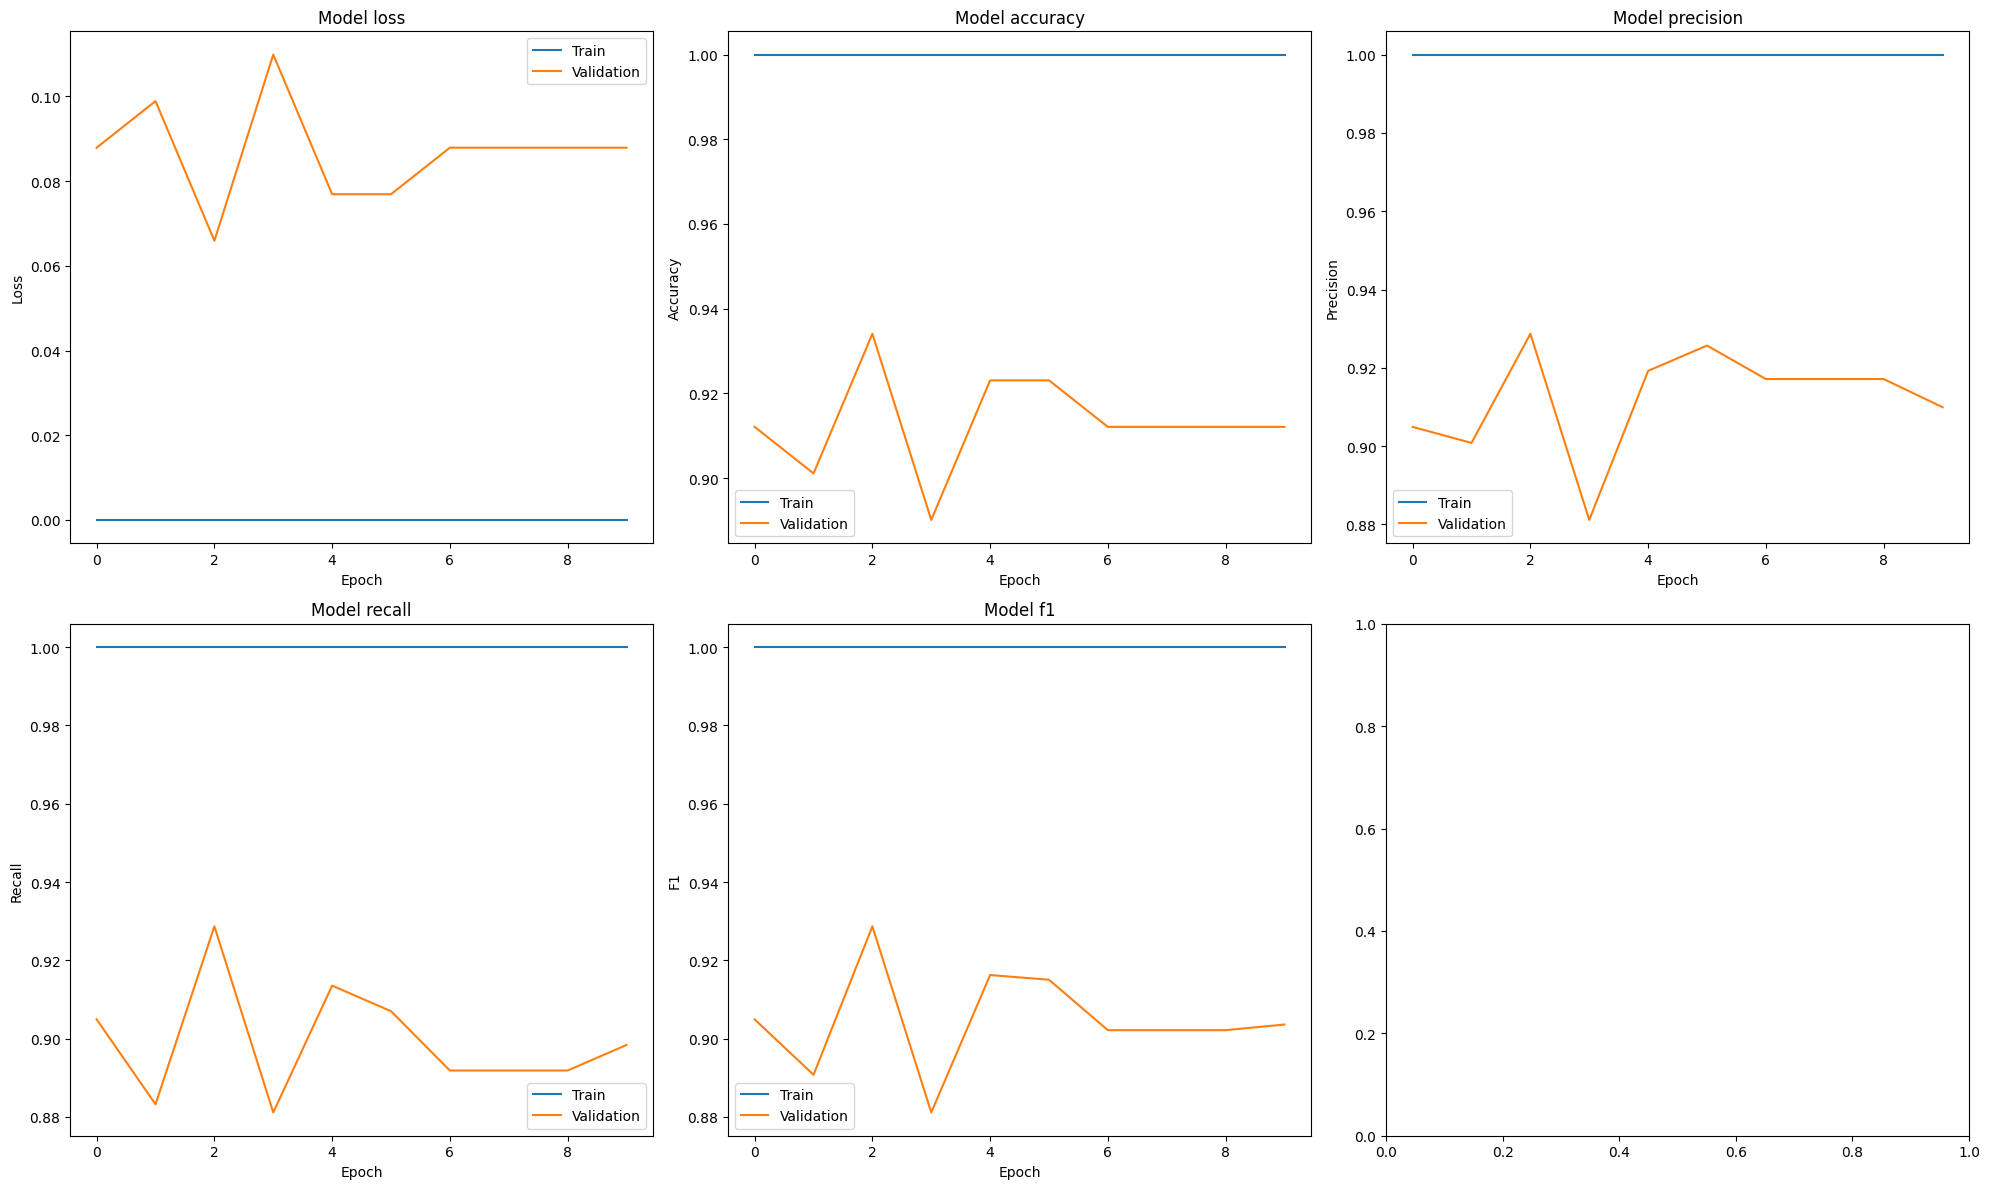

In [7]:
# Plot the training history
model.plot_training_history()